# Prep

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

% cd /content/drive/MyDrive/GitHub\ Projects/21_anomaly_detection

!ls

/content
/content/drive/MyDrive/GitHub Projects/21_anomaly_detection
 1_tY4F3BPq4ctTMelMEnLZvw.png
 arff2csv.py
'Containerized AI for Anomaly Detection _ by Brent Larzalere _ The Startup _ Medium.pdf'
 data_prep.py
 Heart
'LSTM Autoencoder for Anomaly Detection _ by Brent Larzalere _ Towards Data Science.pdf'
 LSTM-Autoencoder-for-Anomaly-Detection-master.zip
 model2.py
 model_a3.pth
 model_best.pth
 model.pth
 model.py
 neverending.pdf
 __pycache__
 readme.md
 seq
 st_app.py
 test2.py
 test3
 test4.py
 test5.py
 test.ipynb
 test.py


In [3]:
!pip install torchinfo

In [4]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from tqdm import tqdm

import torch.nn.functional as F
import torchinfo

from model2 import CNN_Heart
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

random_seed = 23
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Data 


In [5]:


train = pd.read_csv('./ECG_Kaggle/mitbih_train.csv', header=None)
print("The shape of train dataset : ",train.shape)
train.head()


test = pd.read_csv('./ECG_Kaggle/mitbih_test.csv',header=None)
print("The shape of test dataset : ",test.shape)
test.head()

print(train.head())



The shape of train dataset :  (87554, 188)
The shape of test dataset :  (21892, 188)
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0

In [6]:
cols = [*range(187),'target']
print(train.shape)
train.columns = cols
test.column = cols
train.head()
train['target'].value_counts()

(87554, 188)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: target, dtype: int64

In [7]:
target = train.iloc[:,187]
labels = ['Normal beat','Supraventricular premature beat','Premature ventricular contraction','Fusion of ventricular and normal beat','Unclassifiable beat']
print(target.head(), type(target))
 
target_class = dict(zip([0,1,2,3,4], labels))
print(target_class)

time = np.arange(0, 187)*8/1000


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: target, dtype: float64 <class 'pandas.core.series.Series'>
{0: 'Normal beat', 1: 'Supraventricular premature beat', 2: 'Premature ventricular contraction', 3: 'Fusion of ventricular and normal beat', 4: 'Unclassifiable beat'}


In [8]:
lf = lambda x: target_class.get(x)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


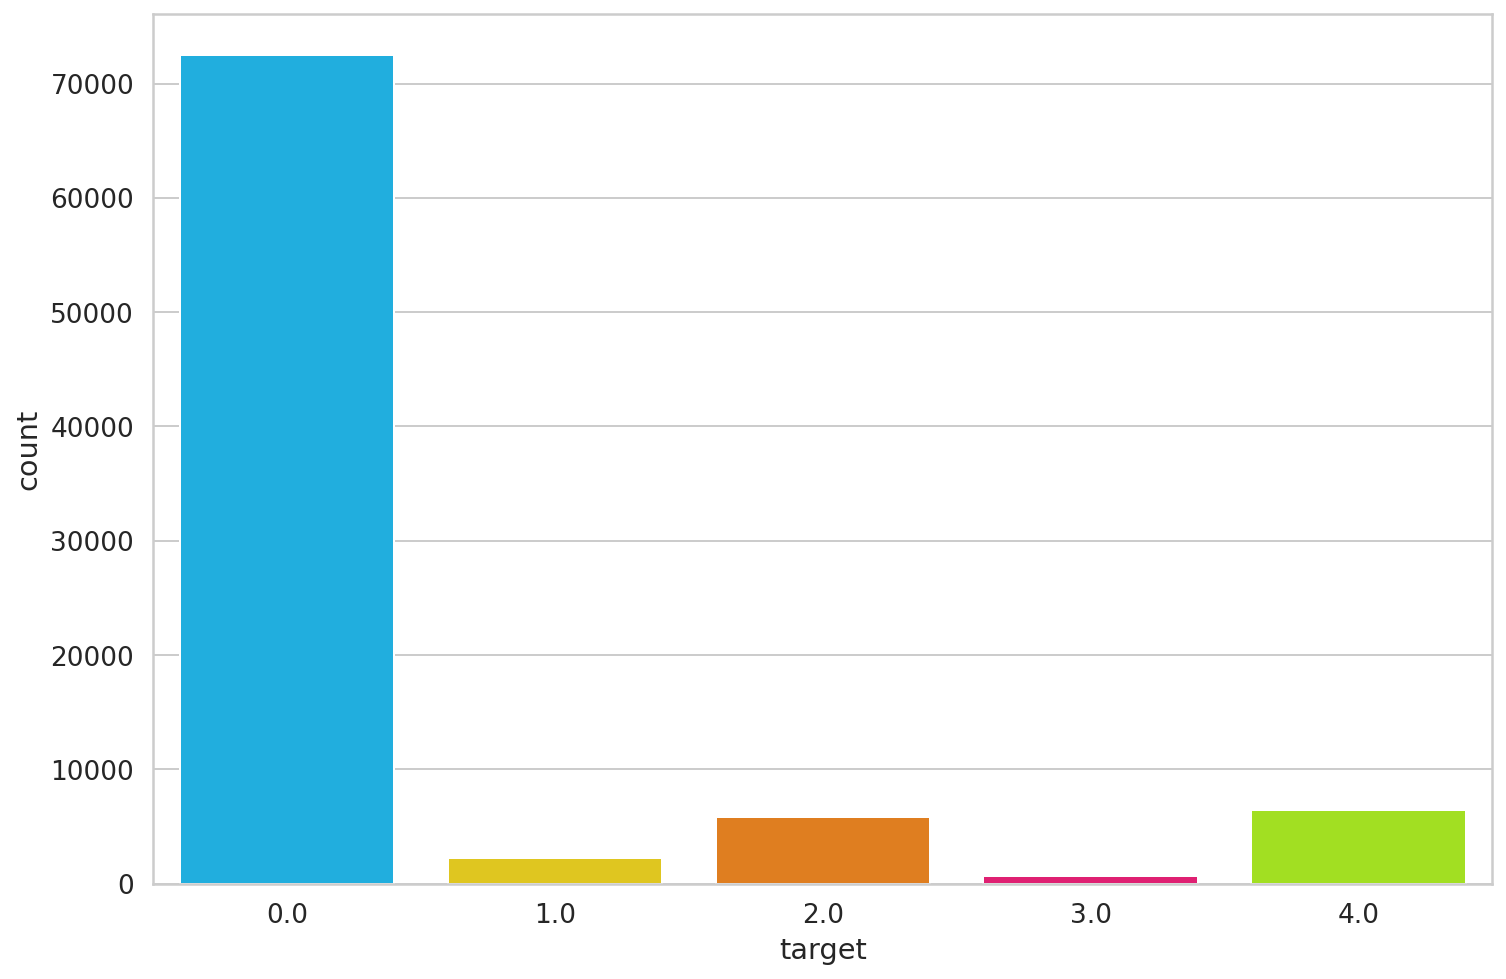

In [9]:
ax = sns.countplot(target)

sns.set_theme(style="darkgrid")


In [10]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.5
  )
  ax.set_title(class_name)

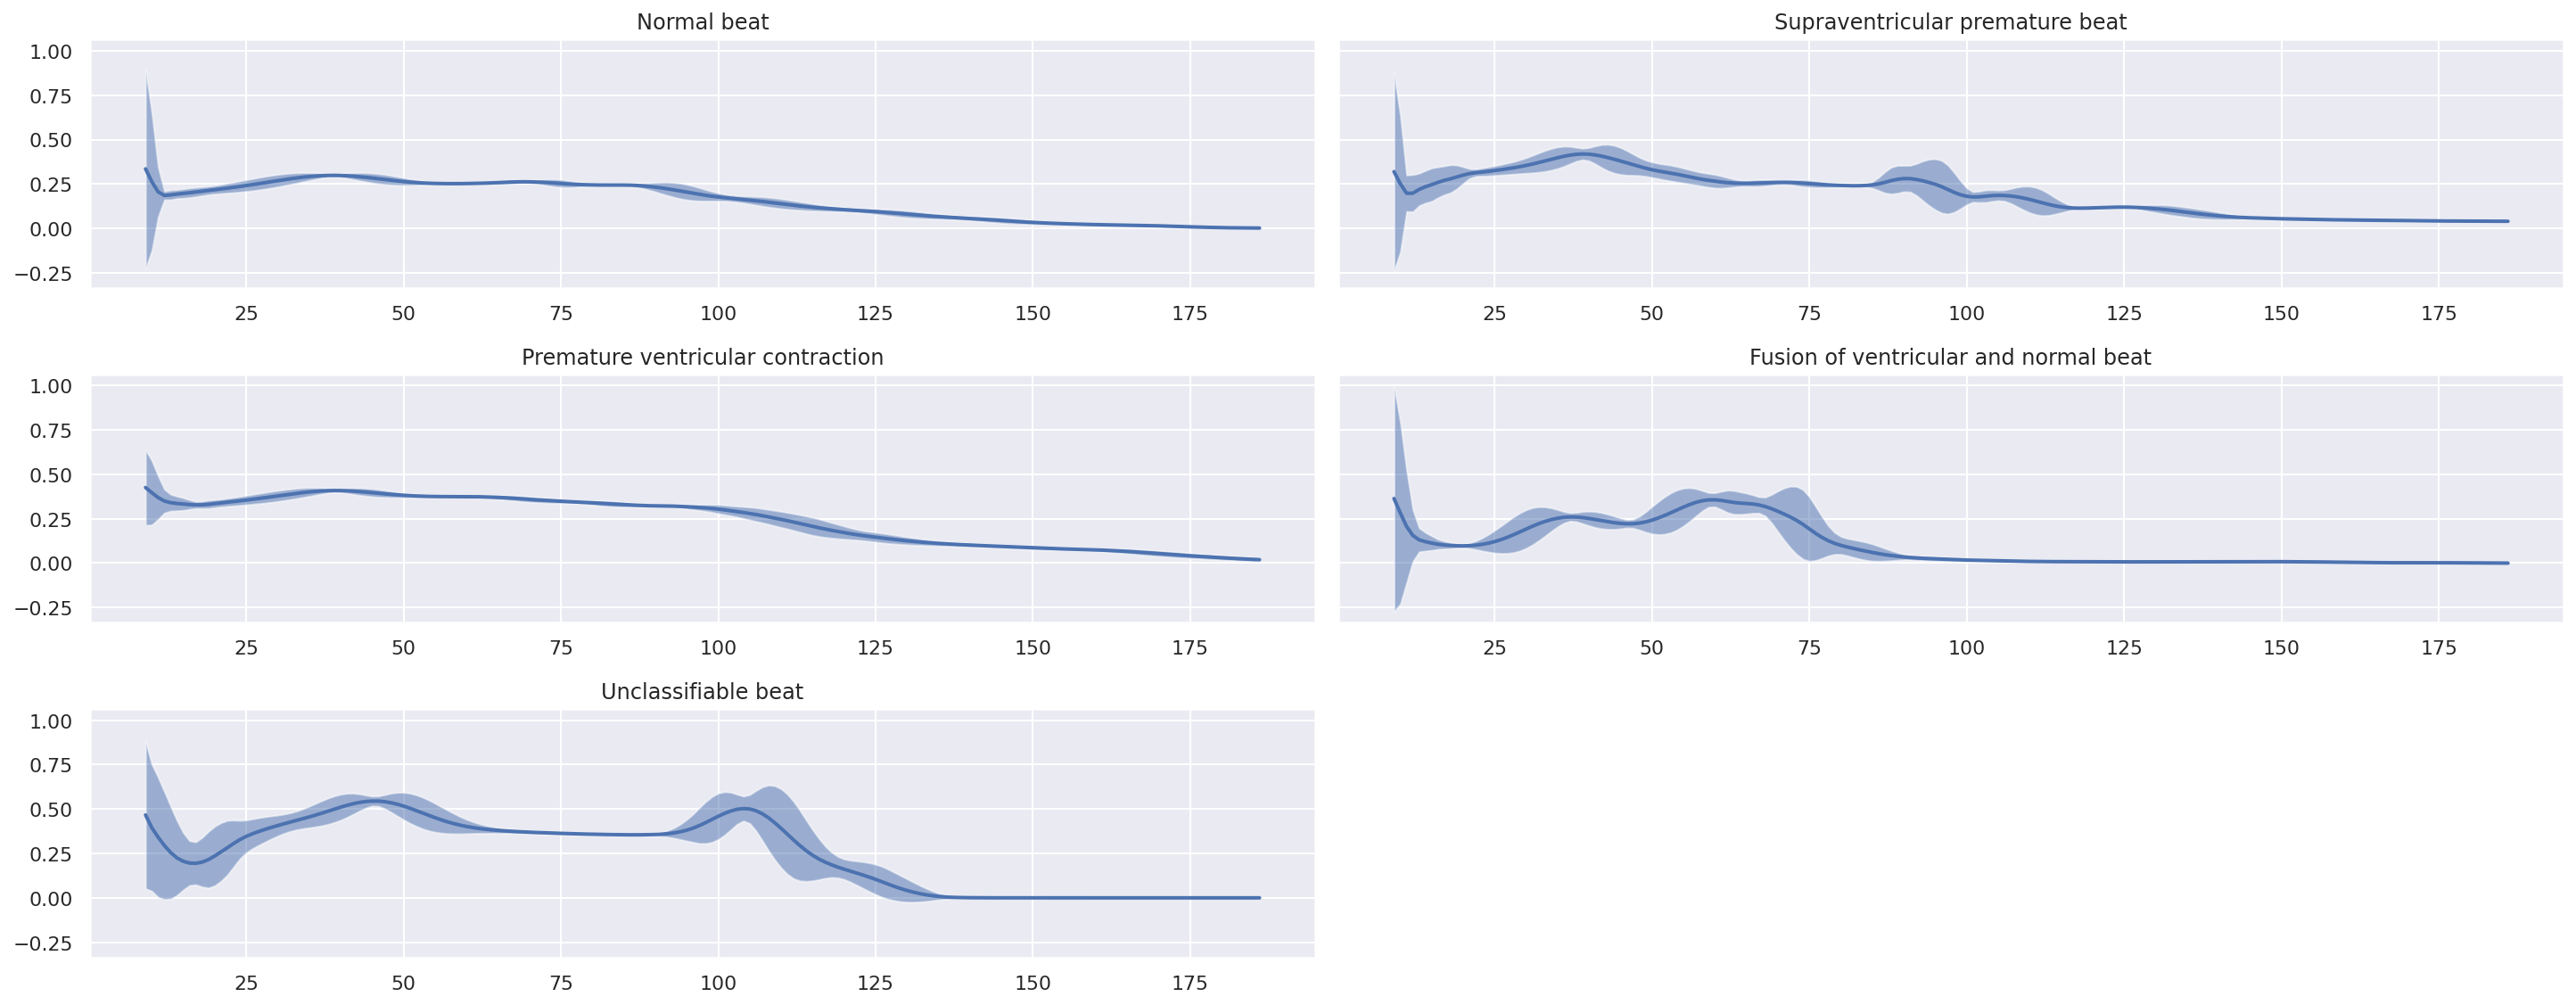

In [11]:
classes = target.unique().astype(int)

ncols = 2
fig, axs = plt.subplots(
  nrows=len(classes) // ncols + 1,
  ncols=ncols,
  sharey=True,
  figsize=(20, 8)
  )

# check the mean og all signals

for i, target_c in enumerate(classes):
  
  ax = axs.flat[i]
  data = train[train.target == target_c].drop(labels='target', axis=1).mean(axis=0).to_numpy()
  plot_time_series_class(data, target_class.get(target_c), ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();


# Rest

In [12]:
# Check if the values are normalized
train.describe().iloc[7,:187].max()


1.0

In [13]:
train_df, test_df = train_test_split( train, test_size=0.20, random_state=random_seed)
train_df.head()


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,target
5865,0.947368,0.783158,0.469474,0.206316,0.050526,0.000000,0.016842,0.033684,0.048421,0.050526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8745,1.000000,0.719745,0.144374,0.000000,0.078556,0.084926,0.084926,0.072187,0.061571,0.053079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52930,1.000000,0.724265,0.034926,0.086397,0.090074,0.115809,0.165441,0.158088,0.167279,0.158088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13899,0.917895,0.924211,0.395789,0.000000,0.183158,0.349474,0.322105,0.298947,0.307368,0.311579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41983,1.000000,0.753191,0.497872,0.285106,0.089362,0.093617,0.178723,0.234043,0.234043,0.263830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
from torch.utils.data import DataLoader, Dataset

class Hearbeat(Dataset):
    def __init__(self, data_df):
        self.target = data_df['target'].to_numpy()
        self.beat = data_df.drop(labels='target', axis=1)
        
    def __len__(self):
        return len(self.beat)

    def __getitem__(self, idx):
            beat = self.beat.iloc[idx,:]
            target = self.target[idx]
            return torch.tensor(beat).type(torch.float32), torch.tensor(target).type(torch.LongTensor)

In [81]:
train_df_short = train_df.iloc[:300,:]
test_df_short = test_df.iloc[:300,:]


In [82]:
train_ds = Hearbeat(train_df)
test_ds = Hearbeat(test_df)
x,y = train_ds[0]
print(type(x), type(y))
l, _ = train_ds[0]
seq_len = l.shape[0]
n_classes = 5

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [83]:
print(seq_len, n_classes)
print('Train: ',len(train_ds), 'Test: ', len(test_ds))
print(test_ds[4])



187 5
Train:  70043 Test:  17511
(tensor([0.9826, 0.9749, 0.6660, 0.2973, 0.1950, 0.1873, 0.1506, 0.1313, 0.1236,
        0.1236, 0.1255, 0.1120, 0.1062, 0.1100, 0.1100, 0.1081, 0.0946, 0.0888,
        0.1004, 0.0830, 0.0598, 0.0425, 0.0425, 0.0251, 0.0077, 0.0019, 0.0000,
        0.0135, 0.0212, 0.0386, 0.0734, 0.0985, 0.1293, 0.1564, 0.1776, 0.1834,
        0.1834, 0.1873, 0.1931, 0.1911, 0.1931, 0.1969, 0.1931, 0.1931, 0.1853,
        0.1853, 0.1911, 0.1892, 0.1776, 0.1892, 0.2066, 0.2181, 0.2278, 0.2568,
        0.2741, 0.3031, 0.3224, 0.3031, 0.3012, 0.2934, 0.2606, 0.2336, 0.2239,
        0.1988, 0.1853, 0.1911, 0.1931, 0.1873, 0.1873, 0.2124, 0.3764, 0.6158,
        0.8417, 1.0000, 0.9633, 0.6236, 0.2876, 0.2085, 0.1873, 0.1313, 0.1178,
        0.1236, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      

In [84]:
#Dataloader

train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=True)


In [85]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
beat0 = train_features[0].squeeze()
label0 = train_labels[0]
# print(beat0, label0)

Feature batch shape: torch.Size([32, 187])
Labels batch shape: torch.Size([32])


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:

model = CNN_Heart(seq_len, n_classes)
model = model.to(device)
print(model)

CNN_Heart(
  (fc1): Linear(in_features=187, out_features=128, bias=True)
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=480, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)


In [58]:
def train_model_dl(model, train_dl, test_dl, n_epochs):
  # optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  # criterion = nn.L1Loss(reduction='sum').to(device)
  
  history = dict(train=[], val=[])
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01)

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for i, (seq, target) in enumerate(train_dl):
      optimizer.zero_grad()
      seq = seq[:, None, :].to(device).float()
      target = target.to(device)
      # seq = seq.float()
      # target.to(device)
      output = model(seq)
      # print('output ', output.shape, 'target  ', target.shape, 'seq  ', seq.shape)
      # print('output ', output, 'target  ', target)

      loss = criterion(output, target)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for i, (seq, target) in enumerate(test_dl):
        seq = seq[:, None, :].to(device).float()
        # seq = seq.to(device)
        # seq = seq.float()
        target = target.to(device)
        output = model(seq)
        loss = criterion(output, target)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model, './model_best.pth')

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    if epoch > 2:
        if history['train'][epoch-1] >= history['train'][epoch-2] and history['train'][epoch-1] >= history['train'][epoch-3]:
            print(f"The convergence of the Neural Network has stalled, exiting the loop....")
            break
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [59]:
model, history = train_model_dl(model, train_dataloader, test_dataloader, n_epochs=30)

Epoch 1: train loss 0.1315574998840351 val loss 0.13446029113863942
Epoch 2: train loss 0.11945020983367052 val loss 0.12617583793288872
Epoch 3: train loss 0.11060456853732636 val loss 0.12373258676345929
Epoch 4: train loss 0.1043656159571192 val loss 0.1163423487314968
Epoch 5: train loss 0.098753503424104 val loss 0.11459976384402627
Epoch 6: train loss 0.09442314820265411 val loss 0.11664558821323796
Epoch 7: train loss 0.0904974512119389 val loss 0.11585156829096377
Epoch 8: train loss 0.08698247989887255 val loss 0.11663829609343823
Epoch 9: train loss 0.08385601543328716 val loss 0.1159507846000883
Epoch 10: train loss 0.08179068519142889 val loss 0.11330063624841154
Epoch 11: train loss 0.07920843512175095 val loss 0.1100743780499766
Epoch 12: train loss 0.07653306138179702 val loss 0.11249673802976626
Epoch 13: train loss 0.07429314977128838 val loss 0.11461620565748563
Epoch 14: train loss 0.07170895538832091 val loss 0.12333519576605151
Epoch 15: train loss 0.07075465686920

In [60]:
print(history['train'])

[0.1315574998840351, 0.11945020983367052, 0.11060456853732636, 0.1043656159571192, 0.098753503424104, 0.09442314820265411, 0.0904974512119389, 0.08698247989887255, 0.08385601543328716, 0.08179068519142889, 0.07920843512175095, 0.07653306138179702, 0.07429314977128838, 0.07170895538832091, 0.07075465686920611, 0.06823545156125777, 0.06601516043927623, 0.06394577148417138, 0.06259607946181196, 0.0612518101835263, 0.06130937472583688, 0.05840996129977759, 0.05790234854189163, 0.05629790835254841, 0.05497192124413988, 0.053918299944339554, 0.05346476749238403, 0.051547359544992837, 0.05116963321288021, 0.05034506799575102]


In [61]:
torch.save(model, './model_cnn1.pth')

In [62]:
from torch import IntTensor

In [125]:

model.to(device)
beats, target = next(iter(test_dataloader))
# print(beats.shape)
beats = torch.unsqueeze(beats, dim =1).to(device)
# print(beats.shape)
r = beats.shape[0]
# print(beats, target)
# print(model)
accuracy = []
with torch.no_grad():
  for i, (beats, target) in enumerate(test_dataloader):
    # print(beats.shape)
    beats = torch.unsqueeze(beats, dim =1).to(device)
    # print(beats.shape)
    y_pred = np.zeros(r, dtype = int)
    ps = model.forward(beats)
    ps = F.softmax(ps, dim = 1)
    y_pred = torch.argmax(ps,dim=1).to('cpu')
    y_pred = y_pred.numpy()
    y_test = target.numpy()    
    # print(y_test, y_pred, np.mean(y_test == y_pred))

    accuracy.append(np.mean(y_test == y_pred))
                    

print('Accuracy of the model is: ', np.mean(accuracy))

Accuracy of the model is:  0.9710880474452555
